In [1]:
from ecell4 import *
import numpy as np
%matplotlib inline
import math
import sys
import matplotlib.pyplot as plt
from ecell4.extra import ensemble

def run(run,rv,Dc,Dt,L,phi,phit,duration):
    rng = core.GSLRandomNumberGenerator(run)
    dt = (2*rv)**2 / (6*Dt)
    tt = np.logspace(math.log10(dt),math.log10(duration),40)
    tt = np.insert(tt,0,[0,dt])
    with species_attributes():
        C | {'D':str(Dc),'radius':str(rv)}
        T | {'D':str(Dt),'radius':str(rv)}
    m=get_model()

    msd = np.zeros(len(tt),float)
    w = spatiocyte.SpatiocyteWorld(Real3(L,L,L),rv,rng)
    (c,r,l)=w.shape()
    Nev=(c - 2) * (r - 2) * (l - 2)
    Nt=int(Nev*phit)
    Nc=int(Nev*phi-Nt)
    if run==1:
        print('run{},rv{},Dc{},Dt{},L{},\n total empty voxels{},Nt{},Nc{},phi{},phit{:.2},dt{:.3},duration{}'.format(
            run,rv,Dc,Dt,L,Nev,Nt,Nc,phi,Nt/Nev,dt,tt[-1]))
    w.bind_to(m)
    w.add_molecules(Species('C'),Nc)
    w.add_molecules(Species('T'),Nt)
    sim = spatiocyte.SpatiocyteSimulator(w)
    pids = [pid for pid, p in w.list_particles(Species("T"))] #particle IDs
    obs = TimingTrajectoryObserver(tt,pids,True,dt)
    sim.run(tt[-1],obs)
    data=obs.data()
    for i in range(Nt):
        msd += np.array(
            [np.linalg.norm(np.array(tuple(pos)) - np.array(tuple(data[i][0]))) ** 2
                 for pos in data[i]])  
    return msd,tt

def singlerun(job,job_id,task_id):
    job.update({'run':task_id})
    out=run(**job)
    return out

In [ ]:
simrun=65
nproc=65
L=1.
rv=0.005
Dc=1.
Dt=1.
phit=0.01
duration=1.
for phi in np.arange(0.1,1,0.1):
    w = spatiocyte.SpatiocyteWorld(Real3(L,L,L),rv)
    (c,r,l)=w.shape()
    Nev=(c - 2) * (r - 2) * (l - 2)
    Nt=int(Nev*phit)
    jobs=[{'rv':rv,'Dc':Dc,'Dt':Dt,'L':L,'phi':phi,'phit':phit,'duration':duration}]
    output=ensemble.run_multiprocessing(singlerun,jobs,n=simrun,nproc=nproc)
    output=np.array(output)
    tt=output[0][1][1]
    msd=np.mean(output[0][:,0],axis=0)/Nt
    name='/home/chew/outputdata/LS3Dcrowd_Dt{}Dc{}phi{:.3}phit{:.3}Nt{}rm{:.3}L{}'.format(Dt,Dc,phi,phit,Nt,rv,L)
    f=open(name,'w')
    np.savetxt(name,np.column_stack([tt,msd]),delimiter=',')
    f.close()    

run1,rv0.005,Dc1.0,Dt1.0,L1.0,
 total empty voxels1467168,Nt14671,Nc132045,phi0.1,phit0.01,dt1.67e-05,duration1.0
run1,rv0.005,Dc1.0,Dt1.0,L1.0,
 total empty voxels1467168,Nt14671,Nc278762,phi0.2,phit0.01,dt1.67e-05,duration1.0
run1,rv0.005,Dc1.0,Dt1.0,L1.0,
 total empty voxels1467168,Nt14671,Nc425479,phi0.30000000000000004,phit0.01,dt1.67e-05,duration1.0


In [ ]:
for phi in np.arange(0.1,1,0.1):
    name='/home/chew/outputdata/LS3Dcrowd_Dt{}Dc{}phi{:.3}phit{:.3}Nt{}rm{:.3}L{}'.format(Dt,Dc,phi,phit,Nt,rv,L)
    dat=np.genfromtxt(name,delimiter=',')
    t=dat.T[0]
    msd=dat.T[1]
    Deff =msd[1:]/t[1:]/6/Dt
    plt.figure(1)
    plt.legend(loc='best')
    plt.loglog(tt,msd,'.-',label='phi='+str(phi))
    plt.figure(2)
    plt.semilogx(tt[1:],Deff,'.-',label='phi='+str(phi))
    plt.legend(loc='best')

No handles with labels found to put in legend.


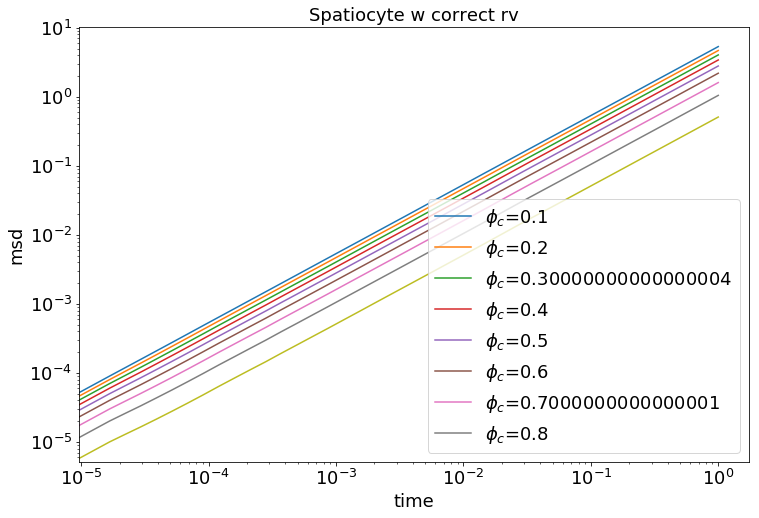

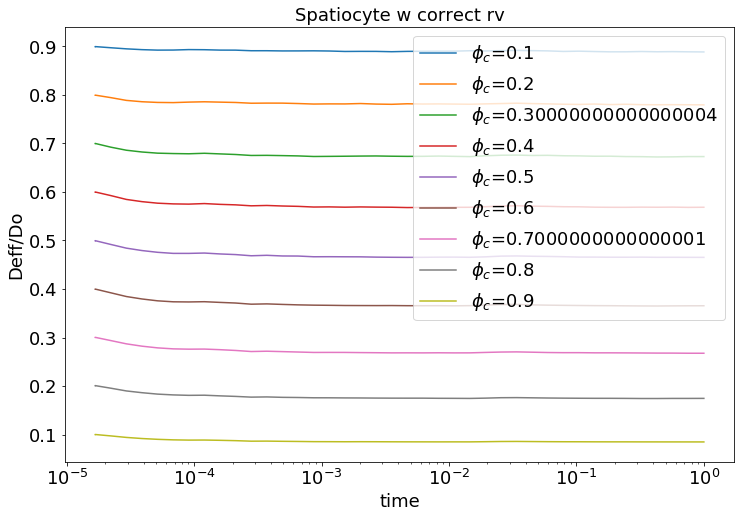

In [24]:
from ecell4 import *
import numpy as np
%matplotlib inline
import math
import sys
import matplotlib.pyplot as plt
from ecell4.extra import ensemble
L=1.
rv=0.005
Dc=1.
Dt=1.
phit=0.01
duration=1.
Nt=14671
Deffs=[]
phis = np.arange(0.1,1.,0.1)
for phi in phis:
    name='/home/chew/outputdata/LS3Dcrowd_Dt{}Dc{}phi{:.3}phit{:.3}Nt{}rm{:.3}L{}'.format(Dt,Dc,phi,phit,Nt,rv,L)
    dat=np.genfromtxt(name,delimiter=',')
    t=dat.T[0]
    msd=dat.T[1]
    Deff =msd[1:]/t[1:]/6/Dt
    fig=plt.figure(1)
    s=18
    fig.set_size_inches(12,8)
    plt.legend(loc='best',fontsize=s)
    plt.loglog(t,msd,'-',label='$\phi_c$='+str(phi))
    plt.xlabel('time',fontsize=s)
    plt.ylabel('msd',fontsize=s)
    plt.tick_params(labelsize=s)
    plt.title('Spatiocyte w correct rv',fontsize=s)
    #plt.savefig('/home/chew/ecellwork/figure/3Dcrowding_Spa_msd_t.png')
    fig=plt.figure(2)
    fig.set_size_inches(12,8)
    plt.tick_params(labelsize=s)
    plt.semilogx(t[1:],Deff,'-',label='$\phi_c$='+str(phi))
    plt.legend(loc='best',fontsize=s)
    plt.xlabel('time',fontsize=s)
    plt.title('Spatiocyte w correct rv',fontsize=s)
    plt.ylabel('Deff/Do',fontsize=s)
    #plt.savefig('/home/chew/ecellwork/figure/3Dcrowding_Spa_Deff_t.png')
    Deffs.append(np.mean(Deff[-7:]))

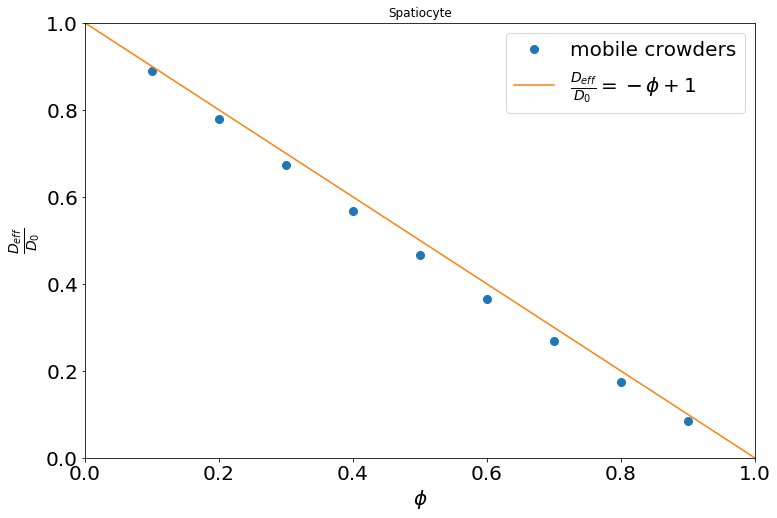

In [56]:
fig=plt.figure()
fig.set_size_inches(12,8)
plt.title('Spatiocyte')
plt.plot(phis,Deffs,'o',markersize=8,label='mobile crowders')
plt.ylim(0,1)
plt.xlim(0,1)
s=20
plt.tick_params(labelsize=s)
plt.plot(np.arange(0,1.1,0.05),[-1*i+1 for i in np.arange(0,1.1,0.05)],label='$\\frac{D_{eff}}{D_0}=-\phi+1$')
plt.xlabel('$\phi$',fontsize=s)
plt.ylabel('$\\frac{D_{eff}}{D_0}$',fontsize=s)
plt.legend(fontsize=s)
#plt.savefig('/home/chew/ecellwork/figure/3Dcrowding_Spa_Deff_phic.png')

1.0379659014863483
[-2.00350717  0.97701818]


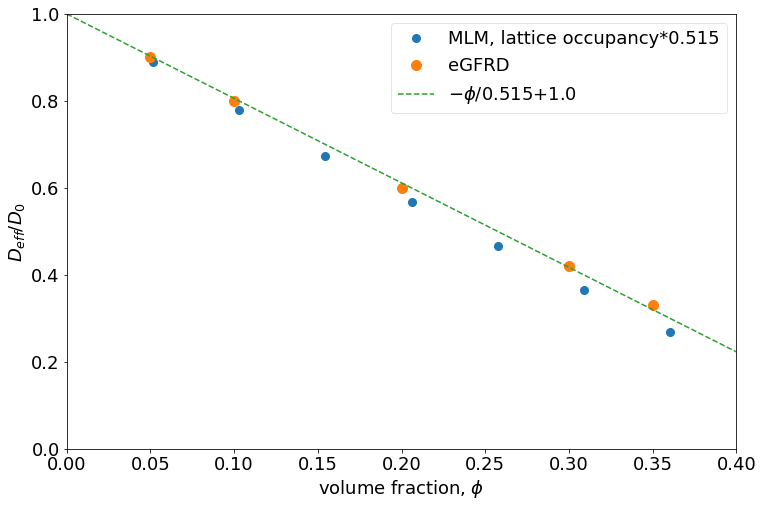

In [30]:
c=(6*2**0.5+4*3**0.5+3*6**0.5)/72.
import math
import numpy as np
print((math.pi*0.74/3/2**0.5/0.49)**(1./3))
phic=math.pi*0.74/(1.021)**3/3/2**0.5
d=lambda x:(1-x/0.58)**2 #w hydrodynamic coupling
g=lambda x:(1-x)**3 /(1-x/2)#enskog theory
xx=np.arange(0,0.58,0.01)
y=np.array([d(i) for i in xx])
y1=np.array([g(i) for i in xx])
lj=lambda x: 1+0.278*x+3.99*x**2+26.5*x**3-134.*x**4+110.7*x**5 #lennardjones potential Heyes et al. 2007

Dlj=np.array([ lj(i)*g(i) for i in xx])
phi=[0.05,0.1,0.2,0.3,0.35]
deff=[0.9,0.8,0.6,0.42,0.33]
xcut=0.3
xfit=xx[xx<xcut]
tofit=y1[xx<xcut]
z=np.polyfit(xfit,tofit,1)
print(z)
z2=[-1/phic,1.]
p=np.poly1d(z)
p2=np.poly1d(z2)

s=18
fig,ax=plt.subplots()
plt.plot(phis[:-2]*0.515,Deffs[:-2],'o',markersize=8,label='MLM, lattice occupancy*0.515')
#plt.plot(phis[:-2]*0.74,Deffs[:-2],'o',markersize=8,label='MLM, lattice occupancy*0.74')
plt.plot(phi,deff,'o',label='eGFRD',markersize=10)
#plt.plot(xx,y,'-.',label='w hydrod. coupling, $1-\phi/0.58$')
#plt.plot(xx,y1,'k-',label='enskog theory,$\\frac{(1-\phi)^3}{1-\phi/2}$')
#plt.plot(xx,[p(i) for i in xx],'--',label='fit of e.t.$-\phi/{:.3}$+{:.3}'.format(-1./z[0],z[1]))
plt.plot(xx,[p2(i) for i in xx],'--',label='$-\phi/{:.3}$+{:.3}'.format(-1./z2[0],z2[1]))
#plt.plot(xx,Dlj,'r-')
plt.ylim(0,1)
plt.xlim(0,0.4)
plt.tick_params(labelsize=s)
plt.legend(loc='best',fontsize=s,framealpha=0.5)
plt.xlabel('volume fraction, $\phi$',fontsize=s)
plt.ylabel('$D_{eff}/D_0$',fontsize=s)
fig.set_size_inches(12,8)
#plt.savefig('/home/chew/ecellwork/figure/Deff_phi_egfrd_fitting_4CD.png')

In [1]:
3.14*0.74/3/2**0.5/1.021**3

0.5145740595520863

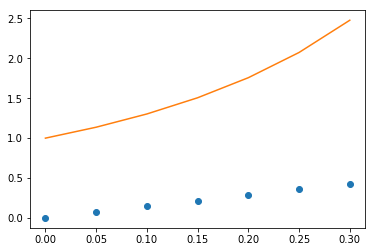

In [8]:
phis=np.arange(0,0.35,0.05)
plt.plot(phis,1.437*phis,'o')
plt.plot(phis,[(1-x/2)/(1-x)**3 for x in phis],'-')

In [1]:
from math import pi,sqrt
(pi/3/sqrt(2)/0.515)**(1./3)

1.128674717885256

In [4]:
3*sqrt(2)*(1.02086)**3/pi

1.436762359873999

In [5]:
1/3/sqrt(2)/1.02086**3

0.22154664896128393

In [7]:
1/(3*sqrt(2)*0.515/0.74/pi)**(1./3)

1.0208909885069113

In [18]:
0.515*(1.0208**3)*8/sqrt(2)

3.0988760272978233

In [19]:
4*pi/3

4.1887902047863905

In [28]:
pi/(3*sqrt(2)*1.0208**3)

0.6961320609350297

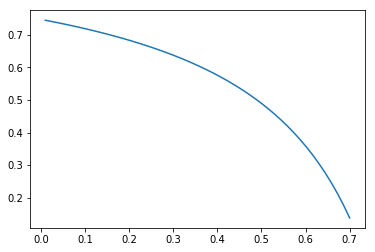

In [54]:
R=1
Deff = lambda D0,phi: D0*(1-phi/0.74)
kphi = lambda phi,ka,Deff: 1./(1/(4*pi*R*Deff)+1/ka)
ps=np.linspace(0.01,0.7)
ka=85
plt.plot(ps,kphi(ps,ka,Deff(20,ps))/ka)